# Sentiment Classification: Machine Learning Approach
This notebook demonstrates sentiment classification using traditional machine learning methods.

**Approach:**
- Load and clean text data (lowercase, remove HTML, numbers, punctuation, stopwords).
- Use TF-IDF vectorization for feature extraction.
- Train a Logistic Regression model with hyperparameter tuning (GridSearchCV).
- Evaluate using accuracy, precision, recall, F1-score, and confusion matrix.
- Save the trained model and vectorizer for future use.

**Assumptions:**
- Input CSVs have at least two columns: text and label (notebook will rename if needed).
- Data is already split into train and test sets via CSVs.
- Labels are binary (0/1 or negative/positive).
- NLTK stopwords are downloaded at runtime if not present.

In [1]:
# Install all required packages
%pip install pandas numpy scikit-learn nltk joblib matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import all necessary libraries for data processing, machine learning, and evaluation
import os
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# Download NLTK stopwords and set up stop words list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fhjib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Define file paths for training and test data (relative to this notebook)
train_path = os.path.join('..', 'Data', 'train_data.csv')
test_path = os.path.join('..', 'Data', 'test_data.csv')

In [4]:
# Load the CSV files into pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
# Ensure both DataFrames have 'text' and 'label' columns, drop missing values, and reset index
for df, name in zip([train_df, test_df], ['train', 'test']):
    cols = list(df.columns)
    if 'text' not in cols or 'label' not in cols:
        print(f"{name} columns found: {cols}")
        if len(cols) >= 2:
            df.rename(columns={cols[0]: 'text', cols[1]: 'label'}, inplace=True)
        else:
            raise ValueError(f"{name} CSV must have at least two columns for text and label.")
    df.dropna(subset=['text', 'label'], inplace=True)
    df.reset_index(drop=True, inplace=True)

train columns found: ['0', '1']
test columns found: ['0', '1']


In [6]:
# Preview the first few rows of both train and test DataFrames
train_df.head(), test_df.head()

(                                                text  label
 0  This film is absolutely awful, but nevertheles...      0
 1  Well since seeing part's 1 through 3 I can hon...      0
 2  I got to see this film at a preview and was da...      1
 3  This adaptation positively butchers a classic ...      0
 4  Råzone is an awful movie! It is so simple. It ...      0,
                                                 text  label
 0  I did not enjoy the film Eraser whatsoever. It...      0
 1  Be very afraid of anyone who likes this film. ...      0
 2  The 3rd and last big screen spin off from the ...      0
 3  Barely three and a half years after just scrap...      1
 4  I'm a big fan of the demonic puppets. Looking ...      0)

In [7]:
# Define a function to clean and preprocess text: lowercase, remove HTML, numbers, punctuation, and stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

In [28]:
# Clean text in both train and test DataFrames
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text']  = test_df['text'].apply(clean_text)

# Preview a few rows to confirm cleaning worked
train_df[['clean_text','label']].head(), test_df[['clean_text','label']].head()

(                                          clean_text  label
 0  film absolutely awful nevertheless hilarious t...      0
 1  well since seeing parts honestly say never mad...      0
 2  got see film preview dazzled typical romantic ...      1
 3  adaptation positively butchers classic beloved...      0
 4  råzone awful movie simple seems tried make mov...      0,
                                           clean_text  label
 0  enjoy film eraser whatsoever awful acting bori...      0
 1  afraid anyone likes film probably inhaled many...      0
 2  rd last big screen spin popular itv sitcom ear...      0
 3  barely three half years scraping months run oc...      1
 4  im big fan demonic puppets looking surface one...      0)

In [11]:
# Vectorize the cleaned text using TF-IDF and prepare features and labels for training/testing
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])
y_train = train_df['label']
y_test = test_df['label']

In [13]:
# Define the hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [14]:
# Perform grid search to find the best Logistic Regression model
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [16]:
# Evaluate the best model from grid search on the test set
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.88256


In [17]:
# Fit the model using grid search and find the best parameters
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid = GridSearchCV(LogisticRegression(max_iter=300, random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
model = grid.best_estimator_
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,300
,multi_class,'deprecated'


In [18]:
# Evaluate the model on the test set and print accuracy, precision, recall, and F1-score
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [19]:
# Print the evaluation metrics for the model
print(f'Accuracy  : {acc:.4f}')
print(f'Precision : {prec:.4f}')
print(f'Recall    : {rec:.4f}')
print(f'F1-score  : {f1:.4f}')

Accuracy  : 0.8826
Precision : 0.8826
Recall    : 0.8826
F1-score  : 0.8826


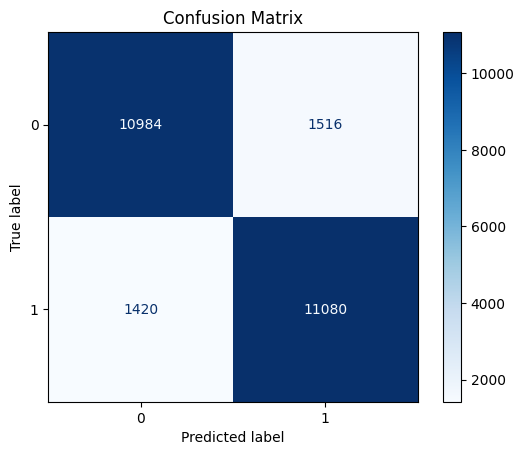

In [34]:
# Visualize the confusion matrix for the model's predictions
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the trained model and vectorizer so you can use them later
os.makedirs('Files', exist_ok=True)
joblib.dump(model, 'Files/model.pkl')
joblib.dump(vectorizer, 'Files/vectorizer.pkl')
'Model & Vectorizer saved successfully.'

'Model & Vectorizer saved successfully.'

In [22]:
# Function to predict sentiment
def predict_sentiment(text):
    cleaned = clean_text(text)
    X = vectorizer.transform([cleaned])
    pred = model.predict(X)[0]
    if str(pred).strip() == '1':
        return 'Positive'
    else:
        return 'Negative'

In [29]:
# Demo: Predict sentiment for a sample sentence
sample_text = "I absolutely love this film! From the breathtaking cinematography to the powerhouse performances, this movie delivers on every level. The director masterfully balances heart-pounding action with emotional depth, leaving me completely invested from start to finish."
print(f"Input: {sample_text}")
print(f"Predicted Sentiment: {predict_sentiment(sample_text)}")

Input: I absolutely love this film! From the breathtaking cinematography to the powerhouse performances, this movie delivers on every level. The director masterfully balances heart-pounding action with emotional depth, leaving me completely invested from start to finish.
Predicted Sentiment: Positive


In [30]:
# Try out the model: predict sentiment for a custom sentence
user_input = input('Enter a sentence: ')
print(f"Input: {user_input}")
print('Predicted sentiment:', predict_sentiment(user_input))

Input: The pacing dragged endlessly, the plot was full of holes, and the characters were so underdeveloped that I couldn’t care less what happened to them. The dialogue felt forced and cringe-worthy, and even the usually reliable seemed bored in their role
Predicted sentiment: Negative
